In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [5]:
from google.colab import files

uploaded = files.upload()  # Opens a file upload prompt


Saving demand_inventory.csv to demand_inventory.csv


In [7]:
# Load dataset
file_path = "demand_inventory.csv"
data = pd.read_csv(file_path)


In [8]:
# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='coerce')

In [9]:
# Drop any missing or incorrectly formatted dates
data.dropna(subset=['Date'], inplace=True)

In [11]:
# Sort data by date
data.sort_values(by='Date', inplace=True)


In [13]:
# Drop unnecessary columns if present
data.drop(columns=['Unnamed: 0', 'Product_ID'], errors='ignore', inplace=True)

In [14]:
# Set Date as index
data.set_index('Date', inplace=True)

In [15]:
# Ensure the data has daily frequency to prevent warnings
data = data.asfreq('D')


In [16]:
# Display the first few rows
print("Dataset Overview:")
print(data.head())

Dataset Overview:
            Demand  Inventory
Date                         
2023-06-01      51       5500
2023-06-02     141       5449
2023-06-03     172       5308
2023-06-04      91       5136
2023-06-05     198       5045


In [24]:
 # Visualizing Demand and Inventory Trends

 data.isnull().sum()


,0
Demand,0
Inventory,0


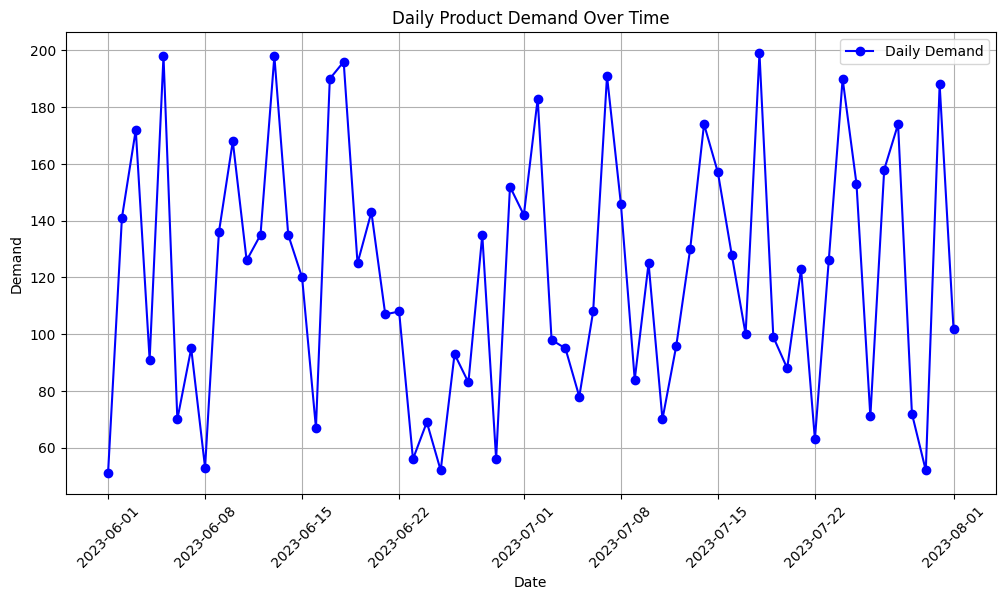

In [18]:
# Plot demand over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Demand'], marker='o', linestyle='-', label='Daily Demand', color='b')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Daily Product Demand Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

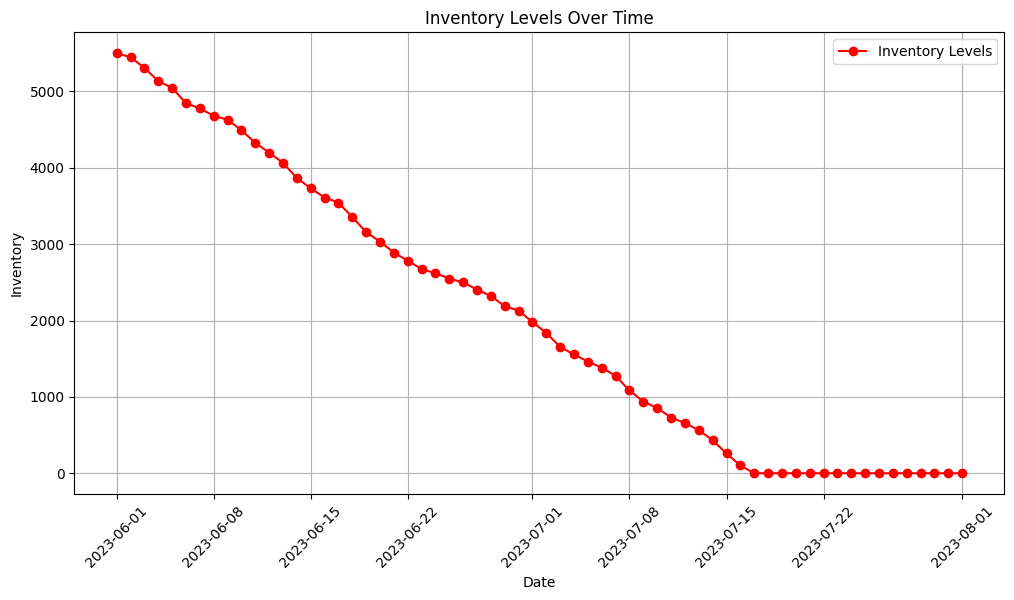

In [19]:
# Plot inventory over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Inventory'], marker='o', linestyle='-', label='Inventory Levels', color='r')
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.title('Inventory Levels Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
 # Time Series Analysis (ACF & PACF)

In [25]:
# Perform differencing to make the time series stationary
differenced_series = data['Demand'].diff().dropna()


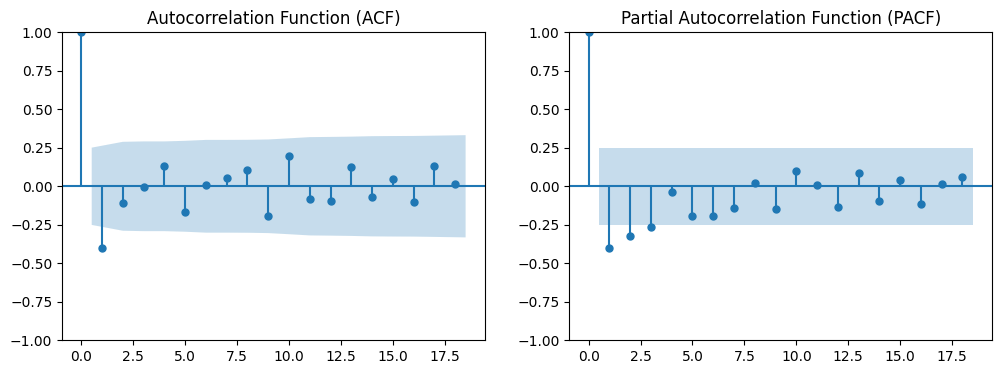

In [26]:
# Plot ACF and PACF to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

In [27]:
# Demand Forecasting using SARIMA

In [28]:
# Define SARIMA model parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2)  # 2-month seasonality

In [29]:
# Fit the SARIMA model
model = SARIMAX(data['Demand'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

In [30]:
# Forecast for the next 10 days
forecast_steps = 10
predictions = model_fit.predict(len(data), len(data) + forecast_steps - 1).astype(int)

In [31]:
# Create date indices for forecasted demand
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

In [32]:
# Store predictions in a DataFrame
forecasted_demand = pd.DataFrame({'Date': future_dates, 'Forecasted_Demand': predictions})
forecasted_demand.set_index('Date', inplace=True)

In [33]:
# Display forecasted demand
print("\nForecasted Demand for the Next 10 Days:")
print(forecasted_demand)


Forecasted Demand for the Next 10 Days:
            Forecasted_Demand
Date                         
2023-08-02                117
2023-08-03                116
2023-08-04                130
2023-08-05                114
2023-08-06                128
2023-08-07                115
2023-08-08                129
2023-08-09                115
2023-08-10                129
2023-08-11                115


In [34]:
# Save forecasted demand to CSV
forecasted_demand.to_csv("forecasted_demand.csv")
print("Forecast saved as 'forecasted_demand.csv'.")

Forecast saved as 'forecasted_demand.csv'.


In [35]:
# Inventory Optimization Calculations

In [36]:
# Inventory Optimization Parameters
initial_inventory = 5500  # Initial stock level
lead_time = 1  # Assume 1 day lead time
service_level = 0.95  # 95% probability of not stocking out

In [37]:
# Compute mean forecasted demand
mean_forecasted_demand = forecasted_demand['Forecasted_Demand'].mean()

In [38]:
# Compute safety stock using Z-score method
z_score = np.abs(np.percentile(forecasted_demand['Forecasted_Demand'], 100 * (1 - service_level)))
safety_stock = mean_forecasted_demand * lead_time + z_score

In [39]:
# Compute reorder point
reorder_point = mean_forecasted_demand * lead_time + safety_stock

In [40]:
# Compute Economic Order Quantity (EOQ) using Newsvendor formula
order_quantity = np.ceil(mean_forecasted_demand + z_score).astype(int)

In [41]:
# Compute Total Cost (holding cost + stockout cost)
holding_cost = 0.1  # Assumed holding cost per unit per day
stockout_cost = 10  # Assumed cost per unit of shortage
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * max(0, mean_forecasted_demand * lead_time - initial_inventory)
total_cost = total_holding_cost + total_stockout_cost


In [42]:
# Display Inventory Optimization Metrics
inventory_results = pd.DataFrame({
    "Metric": ["Optimal Order Quantity", "Reorder Point", "Safety Stock", "Total Cost"],
    "Value": [order_quantity, reorder_point, safety_stock, total_cost]
})

In [43]:
print("\nInventory Optimization Metrics:")
print(inventory_results)


Inventory Optimization Metrics:
                   Metric   Value
0  Optimal Order Quantity  236.00
1           Reorder Point  356.05
2            Safety Stock  235.25
3              Total Cost  561.80


In [44]:
# Save inventory results to CSV
inventory_results.to_csv("inventory_optimization_metrics.csv", index=False)
print("Inventory metrics saved as 'inventory_optimization_metrics.csv'.")

Inventory metrics saved as 'inventory_optimization_metrics.csv'.
